In [48]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('.')

attributes = dir(writer)
print(attributes)
print(writer.get_logdir())
print(writer.log_dir)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_encode', '_get_file_writer', 'add_audio', 'add_custom_scalars', 'add_custom_scalars_marginchart', 'add_custom_scalars_multilinechart', 'add_embedding', 'add_figure', 'add_graph', 'add_histogram', 'add_histogram_raw', 'add_hparams', 'add_image', 'add_image_with_boxes', 'add_images', 'add_mesh', 'add_onnx_graph', 'add_pr_curve', 'add_pr_curve_raw', 'add_scalar', 'add_scalars', 'add_tensor', 'add_text', 'add_video', 'all_writers', 'close', 'default_bins', 'file_writer', 'filename_suffix', 'flush', 'flush_secs', 'get_logdir', 'log_dir', 'max_queue', 'purge_step']
.


In [5]:
import numpy as np

def read_openfoam_scalar(file_path):
    """Read scalar values from an OpenFOAM file."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize variables
    internal_field_index = None
    uniform_value = None
    expected_count = None
    start_index = None
    end_index = None

    # Find the indices for the internal field values
    for i, line in enumerate(lines):
        if "internalField" in line:
            internal_field_index = i
            if ";" in line: # For uniform fields
                parts = line.split()
                # Assuming format: "internalField uniform <value>;"
                uniform_value = float(parts[-1][:-1])
                return uniform_value  # Return uniform as a 1x1 array
            else:
                # Read the next line for the expected count
                expected_count = int(lines[i + 1].strip())  # Convert to int
                # print(expected_count)
                # Check the next line for "("
                if "(" in lines[i + 2] and ")" in lines[i + 2 + expected_count + 1]:
                    start_index = i + 2  # Start reading values from the next line
                    end_index = i + 2 + expected_count + 1
                    
                    selected_lines = lines[start_index+1:end_index]
                    dim_array = np.loadtxt(selected_lines).reshape(-1, )
                    break  # Exit loop after processing

    return dim_array

In [11]:
T1 = read_openfoam_scalar('/home/xk/Software/6_bohr_agent/deepflame-agent-dev/df_agent/agent/output/df_runs/2D_HIT_1/0/T').reshape(1024, -1)
T2 = read_openfoam_scalar('/home/xk/Software/6_bohr_agent/deepflame-agent-dev/df_agent/agent/output/df_runs/2D_HIT_2/0/T').reshape(1024, -1)
T3 = read_openfoam_scalar('/home/xk/Software/6_bohr_agent/deepflame-agent-dev/df_agent/agent/output/df_runs/2D_HIT_3/0/T').reshape(1024, -1)
print(T1.shape)

(1024, 1024)


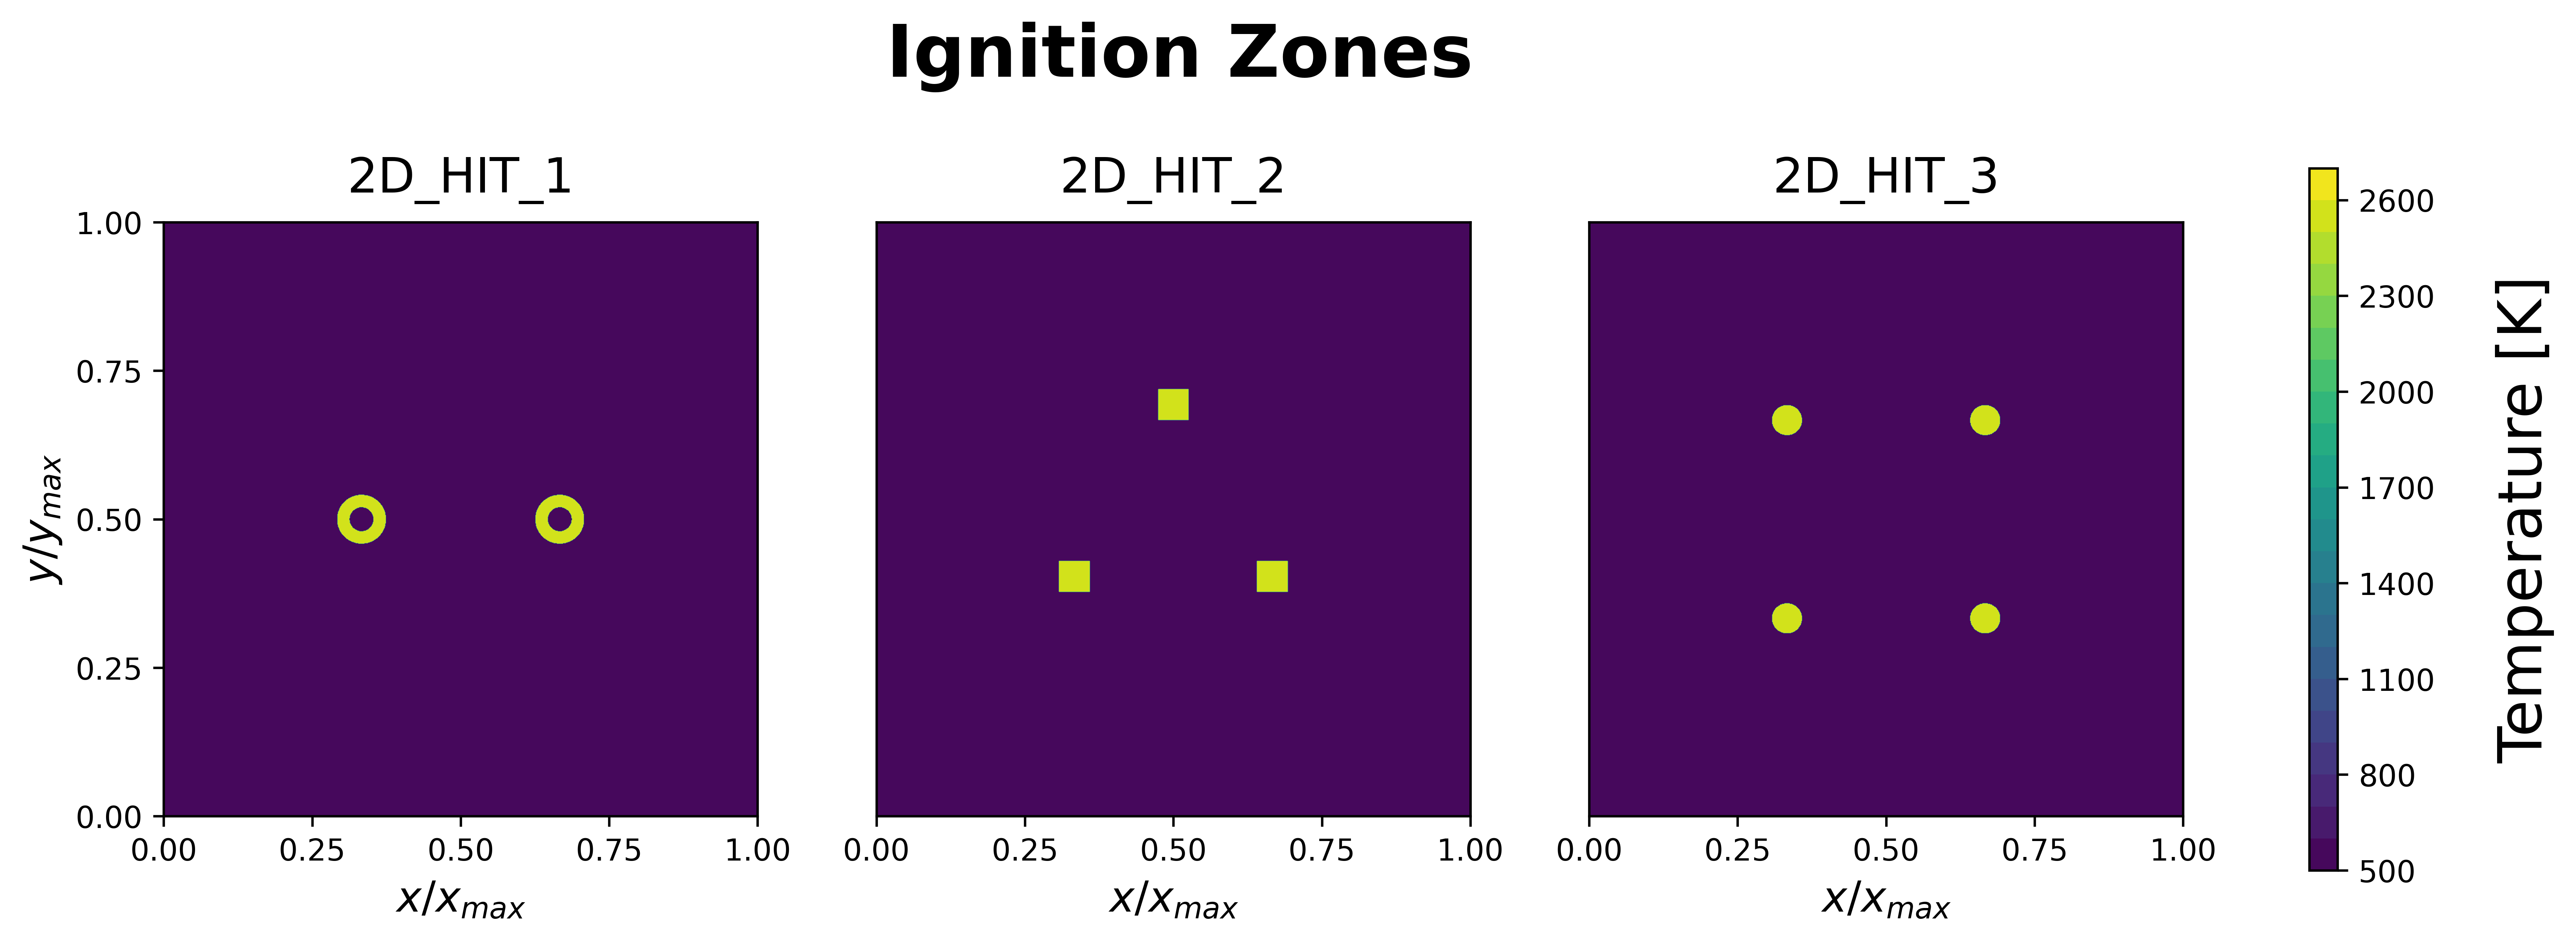

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# T1 = 2562.9164474426
# T0 = 600

# width = 0.05026548245743669

# grid = np.ones((1024, 1024)) * T0

plot_data = [
    T1,
    T2,
    T3,
    T1,
    T2,
    T3,
]

hit_titles = [
    '2D_HIT_1',
    '2D_HIT_2',
    '2D_HIT_3',
]

row_title_size = 24  # Largest for row titles
subplot_title_size = 16  # Second largest for subplot titles
label_size = 14  # Smaller for labels

# Determine global min and max for color scaling
global_min = 500
global_max = 2700

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 6), dpi=600)

# Loop to create 6 snapshots
for i, ax in enumerate(axes.flatten()):
    slice_data = plot_data[i]
    # print(slice_data.shape)
    
    # Create normalized grid
    x = np.linspace(0, 1, slice_data.shape[1])
    y = np.linspace(0, 1, slice_data.shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot the contour using the normalized grid
    contour = ax.contourf(
        X, Y, slice_data, 
        levels=np.linspace(global_min, global_max, 23), 
        cmap='viridis', 
        vmin=global_min, vmax=global_max,
    )
    
    # Set title and labels
    ax.set_title(
        hit_titles[i % 3], 
        fontsize=subplot_title_size, 
        pad=10,
    )
    
    # Set x and y limits to normalized coordinates
    ax.set_xlim(0, 1)  # Normalize x-axis
    ax.set_ylim(0, 1)  # Normalize y-axis

    # Set aspect ratio to 1
    ax.set_aspect('equal', adjustable='box')
    
    # Only label ticks for left column and bottom row
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xlabel(r'$x/x_{max}$', fontsize=label_size)
    if i % 3 == 0:  # Left column
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])  # Y ticks
        ax.set_ylabel(r'$y/y_{max}$', fontsize=label_size)
    else:
        ax.set_yticks([])  # Remove Y ticks for other columns

# Create a shared colorbar
cbar = fig.colorbar(
    contour, ax=axes.ravel().tolist(), 
    orientation='vertical', 
    label='Temperature [K]', 
    shrink=0.7, 
    aspect=25
)
cbar.ax.set_ylabel('Temperature [K]', fontsize=20, labelpad=20)

# Add shared titles for the rows
cntr = 0.437
fig.text(
    cntr, 0.85, 
    'Ignition Zones', 
    ha='center', va='center', 
    fontsize=row_title_size,
    fontweight='bold',
)
# fig.text(
#     cntr, 0.48, 
#     'Model Prediction', 
#     ha='center', va='center', 
#     fontsize=row_title_size,
#     fontweight='bold',
# )

# Save the plot as a JPEG file
filename = "/home/xk/Software/6_bohr_agent/src/images/ignition_zones.jpg"
plt.savefig(filename)
plt.show()
plt.close()

(5, 30, 12, 128, 128)


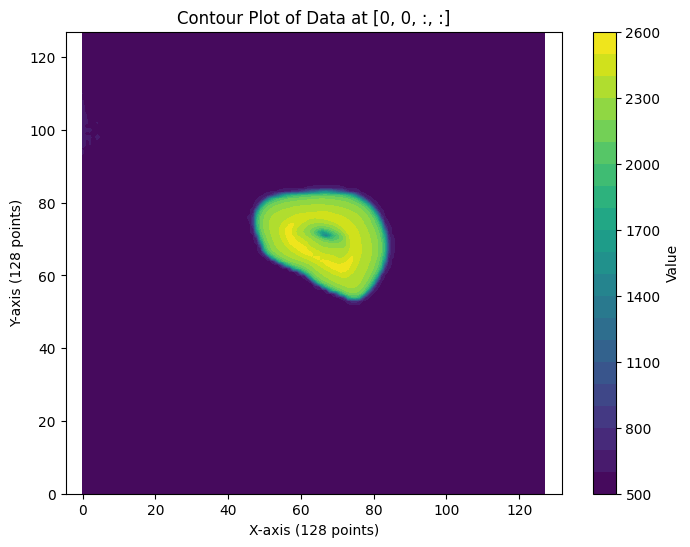

In [49]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('/mnt/d/u_deepflame_agent/hit-best/bestModelResults/CNextv2-seed-0-7_31_3_24_19_52157/states.npy')
print(data.shape)

slice_data = data[4, 6, -4, :, :]

# Create a contour plot
plt.figure(figsize=(8, 6))
plt.contourf(slice_data, levels=20, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Contour Plot of Data at [0, 0, :, :]')
plt.xlabel('X-axis (128 points)')
plt.ylabel('Y-axis (128 points)')
plt.axis('equal')  # To maintain aspect ratio
plt.show()
plt.close()

(5, 30, 12, 128, 128)
(5, 30, 12, 128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)
(128, 128)


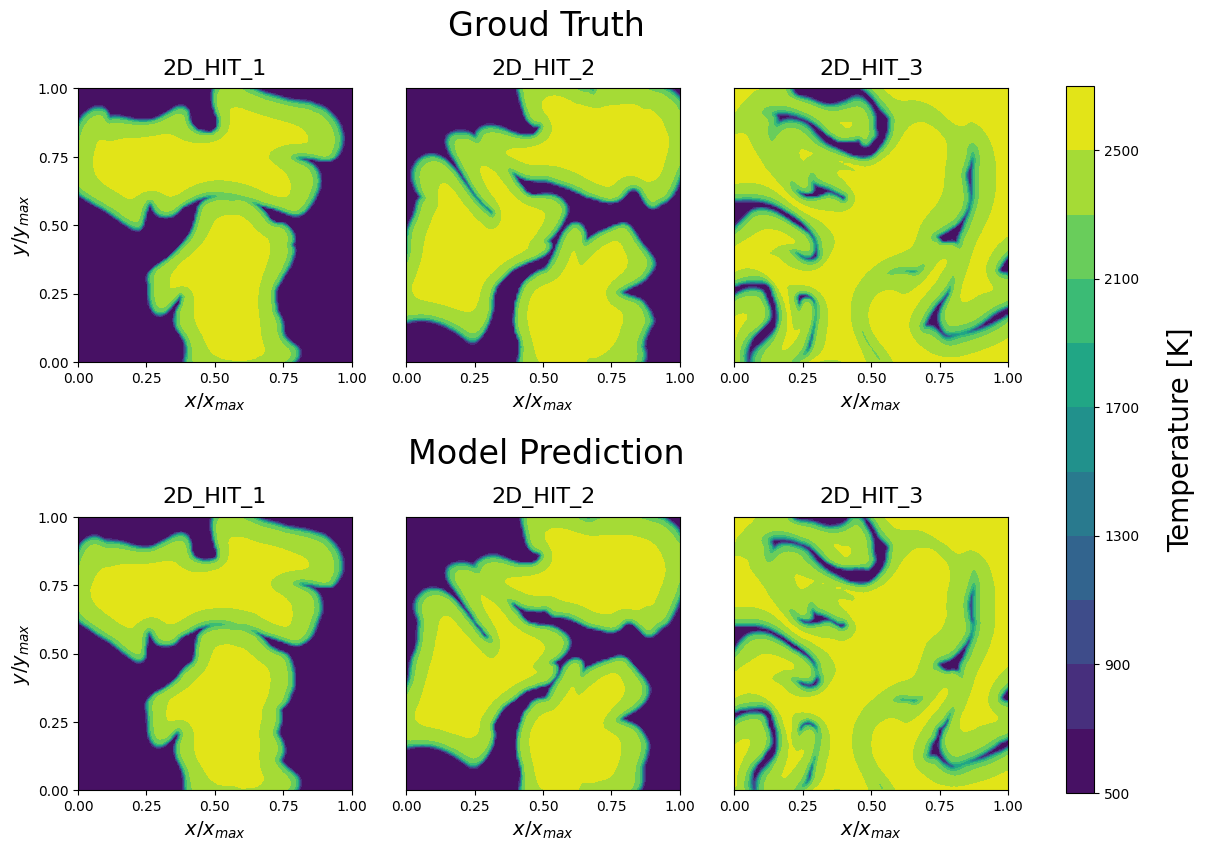

In [75]:

import numpy as np
import matplotlib.pyplot as plt

model_names = [
    'CNextv2-seed-0-7_31_3_24_19_52157',
    'FactFormerv2-seed-0-7_29_15_0_21_64290',
    'FFNO-seed-0-7_31_0_4_7_94912',
]
hit_idxs = [
    1, 2, 0
]
hit_titles = [
    '2D_HIT_1',
    '2D_HIT_2',
    '2D_HIT_3',
]

model_idx = 0
time_idx = -1
field_idx = -4  # Temperature field index

cvode_npz = np.load('/mnt/d/u_deepflame_agent/hit-best/data/hit.npz')
cvode_data = cvode_npz['test_data']
print(cvode_data.shape)

model_data = np.load(f'/mnt/d/u_deepflame_agent/hit-best/bestModelResults/{model_names[model_idx]}/states.npy')
print(model_data.shape)

plot_data = [
    cvode_data[hit_idxs[0], time_idx, -2, :, :],
    cvode_data[hit_idxs[1], time_idx, -2, :, :],
    cvode_data[hit_idxs[2], time_idx, -2, :, :],
    model_data[hit_idxs[0], time_idx, -4, :, :],
    model_data[hit_idxs[1], time_idx, -4, :, :],
    model_data[hit_idxs[2], time_idx, -4, :, :],
]

# Determine global min and max for color scaling
global_min = 500
global_max = 2700

# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10.2))

# Set font sizes
row_title_size = 24  # Largest for row titles
subplot_title_size = 16  # Second largest for subplot titles
label_size = 14  # Smaller for labels

# Loop to create 6 snapshots
for i, ax in enumerate(axes.flatten()):
    slice_data = plot_data[i]
    print(slice_data.shape)
    
    # Create normalized grid
    x = np.linspace(0, 1, slice_data.shape[1])
    y = np.linspace(0, 1, slice_data.shape[0])
    X, Y = np.meshgrid(x, y)

    # Plot the contour using the normalized grid
    contour = ax.contourf(X, Y, slice_data, levels=np.linspace(global_min, global_max, 12), cmap='viridis', vmin=global_min, vmax=global_max)
    
    # Set title and labels
    ax.set_title(hit_titles[i % 3], fontsize=subplot_title_size, pad=10)
    
    # Set x and y limits to normalized coordinates
    ax.set_xlim(0, 1)  # Normalize x-axis
    ax.set_ylim(0, 1)  # Normalize y-axis

    # Set aspect ratio to 1
    ax.set_aspect('equal', adjustable='box')
    
    # Only label ticks for left column and bottom row
    ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_xlabel(r'$x/x_{max}$', fontsize=label_size)
    if i % 3 == 0:  # Left column
        ax.set_yticks([0, 0.25, 0.5, 0.75, 1])  # Y ticks
        ax.set_ylabel(r'$y/y_{max}$', fontsize=label_size)
    else:
        ax.set_yticks([])  # Remove Y ticks for other columns

# Create a shared colorbar
cbar = fig.colorbar(
    contour, ax=axes.ravel().tolist(), 
    orientation='vertical', 
    label='Temperature [K]', 
    shrink=0.9, 
    aspect=25
)
cbar.ax.set_ylabel('Temperature [K]', fontsize=20, labelpad=20)

# Add shared titles for the rows
cntr = 0.437
fig.text(cntr, 0.9, 'Groud Truth', ha='center', va='center', fontsize=row_title_size)
fig.text(cntr, 0.48, 'Model Prediction', ha='center', va='center', fontsize=row_title_size)

# Adjust layout
plt.show()
plt.close()

In [77]:

import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # Use imageio.v2 for compatibility
import os

model_names = [
    'CNextv2-seed-0-7_31_3_24_19_52157',
    'FactFormerv2-seed-0-7_29_15_0_21_64290',
    'FFNO-seed-0-7_31_0_4_7_94912',
]
hit_idxs = [
    1, 2, 0
]
hit_titles = [
    '2D_HIT_1',
    '2D_HIT_2',
    '2D_HIT_3',
]

cvode_npz = np.load('/mnt/d/u_deepflame_agent/hit-best/data/hit.npz')
cvode_data = cvode_npz['test_data']
print(cvode_data.shape)

model_data = np.load(f'/mnt/d/u_deepflame_agent/hit-best/bestModelResults/{model_names[model_idx]}/states.npy')
print(model_data.shape)

model_idx = 0
field_idx = -4  # Temperature field index

# Create output directory for images
output_dir = './slices'
os.makedirs(output_dir, exist_ok=True)

# List to store filenames for GIF creation
filenames = []

# Set font sizes
row_title_size = 24  # Largest for row titles
subplot_title_size = 16  # Second largest for subplot titles
label_size = 14  # Smaller for labels

# Loop through the second dimension (30 slices)
for time_idx in range(cvode_data.shape[1]):
    plot_data = [
        cvode_data[hit_idxs[0], time_idx, -2, :, :],
        cvode_data[hit_idxs[1], time_idx, -2, :, :],
        cvode_data[hit_idxs[2], time_idx, -2, :, :],
        model_data[hit_idxs[0], time_idx, -4, :, :],
        model_data[hit_idxs[1], time_idx, -4, :, :],
        model_data[hit_idxs[2], time_idx, -4, :, :],
    ]

    # Determine global min and max for color scaling
    global_min = 500
    global_max = 2700

    # Create a figure with subplots
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Loop to create 6 snapshots
    for i, ax in enumerate(axes.flatten()):
        slice_data = plot_data[i]
        # print(slice_data.shape)
        
        # Create normalized grid
        x = np.linspace(0, 1, slice_data.shape[1])
        y = np.linspace(0, 1, slice_data.shape[0])
        X, Y = np.meshgrid(x, y)

        # Plot the contour using the normalized grid
        contour = ax.contourf(X, Y, slice_data, levels=np.linspace(global_min, global_max, 12), cmap='viridis', vmin=global_min, vmax=global_max)
        
        # Set title and labels
        ax.set_title(
            hit_titles[i % 3], 
            fontsize=subplot_title_size, 
            fontweight='bold',
            pad=10,
        )
        
        # Set x and y limits to normalized coordinates
        ax.set_xlim(0, 1)  # Normalize x-axis
        ax.set_ylim(0, 1)  # Normalize y-axis

        # Set aspect ratio to 1
        ax.set_aspect('equal', adjustable='box')
        
        # Only label ticks for left column and bottom row
        ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
        ax.set_xlabel(r'$x/x_{max}$', fontsize=label_size)
        if i % 3 == 0:  # Left column
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])  # Y ticks
            ax.set_ylabel(r'$y/y_{max}$', fontsize=label_size)
        else:
            ax.set_yticks([])  # Remove Y ticks for other columns

    # Create a shared colorbar
    cbar = fig.colorbar(
        contour, ax=axes.ravel().tolist(), 
        orientation='vertical', 
        label='Temperature [K]', 
        shrink=0.9, 
        aspect=25
    )
    cbar.ax.set_ylabel('Temperature [K]', fontsize=20, labelpad=20)

    # Add shared titles for the rows
    cntr = 0.437
    fig.text(cntr, 0.9, 'Groud Truth', ha='center', va='center', fontsize=row_title_size)
    fig.text(cntr, 0.48, 'Model Prediction', ha='center', va='center', fontsize=row_title_size)

    # Save the plot as a JPEG file
    filename = f"{output_dir}/slice_{time_idx}.jpg"
    plt.savefig(filename)
    plt.close()
    
    # Append filename for GIF
    filenames.append(filename)

# Create a GIF from the saved images
gif_filename = './slices/animations.gif'
images = [imageio.imread(filename) for filename in filenames]

# Add the last frame again for a pause effect
pause_frame = images[-1]  # Get the last image
images.append(pause_frame)  # Add it again for pause

# Save the GIF with a small pause
imageio.mimsave(gif_filename, images, duration=1, loop=0)  # Loop=0 for infinite loop

print(f"GIF saved as {gif_filename}")

(5, 30, 12, 128, 128)
(5, 30, 12, 128, 128)
GIF saved as ./slices/animations.gif


In [52]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # Use imageio.v2 for compatibility
import os

# Load the data
data = np.load('/mnt/d/u_deepflame_agent/hit-best/bestModelResults/CNextv2-seed-0-7_31_3_24_19_52157/states.npy')
data.shape = (5, 30, 12, 128, 128)  # Reshape the array if needed

# Create output directory for images
output_dir = './slices'
os.makedirs(output_dir, exist_ok=True)

# List to store filenames for GIF creation
filenames = []

# Loop through the second dimension (30 slices)
for i in range(data.shape[1]):
    slice_data = data[0, i, 0, :, :]
    
    # Create a contour plot
    plt.figure(figsize=(8, 6))
    plt.contourf(slice_data, levels=20, cmap='viridis')
    plt.colorbar(label='Value')
    plt.title(f'Contour Plot of Data at Slice {i}')
    plt.xlabel('X-axis (128 points)')
    plt.ylabel('Y-axis (128 points)')
    plt.axis('equal')  # To maintain aspect ratio
    
    # Save the plot as a JPEG file
    filename = f"{output_dir}/slice_{i}.jpg"
    plt.savefig(filename)
    plt.close()
    
    # Append filename for GIF
    filenames.append(filename)

# Create a GIF from the saved images
gif_filename = './slices/animation.gif'
images = [imageio.imread(filename) for filename in filenames]

# Add the last frame again for a pause effect
pause_frame = images[-1]  # Get the last image
images.append(pause_frame)  # Add it again for pause

# Save the GIF with a small pause
imageio.mimsave(gif_filename, images, duration=1, loop=0)  # Loop=0 for infinite loop

print(f"GIF saved as {gif_filename}")

GIF saved as ./slices/animation.gif


In [53]:
data = np.load('/mnt/d/u_deepflame_agent/hit-best/data/hit.npz')

for key in data.keys():
    array_shape = data[key].shape
    print(f"Key: {key}, Shape: {array_shape}")

print(data['variables'])

Key: train_data, Shape: (26, 30, 12, 128, 128)
Key: val_data, Shape: (5, 30, 12, 128, 128)
Key: test_data, Shape: (5, 30, 12, 128, 128)
Key: variables, Shape: (12,)
Key: groups, Shape: (36,)
Key: times, Shape: (30,)
Key: spatial_size, Shape: (2,)
Key: coords, Shape: (2, 128, 128)
['H.npy' 'H2.npy' 'H2O.npy' 'H2O2.npy' 'HO2.npy' 'O.npy' 'O2.npy' 'OH.npy'
 'Ux.npy' 'Uy.npy' 'T.npy' 'rho.npy']


In [54]:
import os 
print(os.environ)

environ({'USER': 'xk', 'VSCODE_WSL_EXT_LOCATION': '/mnt/c/Users/xiaox/.vscode/extensions/ms-vscode-remote.remote-wsl-0.99.0', 'SHLVL': '1', 'HOME': '/home/xk', 'WSL_DISTRO_NAME': 'Ubuntu-20.04', 'WAYLAND_DISPLAY': 'wayland-0', 'LOGNAME': 'xk', 'NAME': 'desktop', 'WSL_INTEROP': '/run/WSL/46_interop', 'PULSE_SERVER': 'unix:/mnt/wslg/PulseServer', '_': '/home/xk/miniconda3/envs/bohr_agent/bin/python', 'TERM': 'xterm-color', 'PATH': '/home/xk/miniconda3/envs/bohr_agent/bin:/home/xk/.vscode-server/bin/cb0c47c0cfaad0757385834bd89d410c78a856c0/bin/remote-cli:/home/xk/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/lib/wsl/lib:/mnt/c/Windows/system32:/mnt/c/Windows:/mnt/c/Windows/System32/Wbem:/mnt/c/Windows/System32/WindowsPowerShell/v1.0:/mnt/c/Windows/System32/OpenSSH:/mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common:/mnt/c/Program Files/NVIDIA Corporation/NVIDIA NvDLISR:/mnt/c/WINDOWS/system32:/mnt/c/WINDOWS:/mnt/c/

In [55]:
from df_agent_tools import check_bashrc_loaded, run_allrun_script

check_bashrc_loaded()

ModuleNotFoundError: No module named 'df_agent_tools'

In [ ]:
from litellm import completion
import os

os.environ['DEEPSEEK_API_KEY'] = "sk-d78218515ab846eabceb88b48437fcb6"
response = completion(
    model="deepseek/deepseek-chat", 
    messages=[
       {"role": "user", "content": "hello from litellm"}
   ],
    stream=True
)

for chunk in response:
    print(chunk)

In [ ]:
import os
import litellm
from litellm import completion

os.environ["MOONSHOT_API_KEY"] = "sk-tiSjgtBinVfxzCju4Im6VR5ahzPZ0wAWHG2ZLEFYqiBMdZFg"  # your Moonshot AI API key

messages = [{"content": "Hello, how are you?", "role": "user"}]

# Moonshot call
response = completion(
    model="moonshot/moonshot-v1-8k", 
    messages=messages
)

print(response)